# Clustering of trajectories

In [13]:
import shnitsel as sh
import shnitsel.xarray
import matplotlib.pyplot as plt
import xarray as xr

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

## Workflow in one cell

Text(0, 0.5, 'PC2')

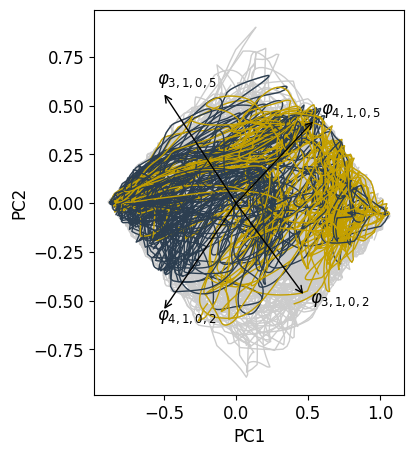

In [131]:
# Load data
homologs = sh.open_frames('/tmp/homologs.nc')

# Calculate and combine descriptors
desc_list = []
atlists = [[3,1,0,5],[3,1,0,2],[4,1,0,5],[4,1,0,2]]
for i, atlist in enumerate(atlists):
    desc = homologs.atXYZ.sh.dihedral(*atlist, full=False, deg=True)
    desc = desc.assign_coords(descriptor=desc.attrs['long_name'])
    desc_list.append(desc)
descriptors = xr.concat(desc_list, dim="descriptor")


# Calculate PCA
dpca, dpca_obj = descriptors.sh.pca('descriptor', return_pca_object=True)
dpca['dih'] = desc_list[1]

# Loadings
loadings = xr.DataArray(
    data=dpca_obj.components_,
    dims=['PC', 'descriptor'],
    coords=dict(
        descriptor=descriptors.descriptor
    )
)

plt.rc('font', size=12)
plt.rc('lines', linewidth=1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 5)

# Grey background:
for (cmpnd, trajid), traj in dpca.sh.mgroupby(['cmpnd', 'trajid']):
        ax.plot(traj[:,0], traj[:,1], c='#ccc', alpha=1)

# Trajectories as lines, coloured by end-dihedral
for trajid, traj in dpca.sel(cmpnd='A03').groupby('trajid'):
    if traj['dih'].isel(frame=-1) < 80:
        c = '#2c3e50'
    elif traj['dih'].isel(frame=-1) > 100:
        c = '#C4A000'
    ax.plot(traj[:,0], traj[:,1], c=c)

# Loadings as arrows
for label, pcs in loadings.groupby('descriptor'):
    pc1, pc2 = pcs.item(0), pcs.item(1)
    # Draw arrow:
    ax.annotate('', xy=(0, 0), xytext=(pc1, pc2), arrowprops=dict(arrowstyle="<-", shrinkA=0, shrinkB=0))
    ax.text(pc1*1.1, pc2*1.1, label)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

## Step-by-step walkthrough

In [2]:
homologs = sh.open_frames('/tmp/homologs.nc')
homologs

<xarray.Dataset> Size: 340MB
Dimensions:    (state: 3, frame: 53332, direction: 3, statecomb: 3, atom: 6,
                trajid_: 255)
Coordinates:
  * state      (state) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
  * trajid_    (trajid_) int32 1kB 2 3 6 13 17 19 20 ... 938 944 947 954 961 969
    atNames    (frame, atom) <U1 1MB ...
  * statecomb  (statecomb) object 24B MultiIndex
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
  * frame      (frame) object 427kB MultiIndex
  * cmpnd      (frame) <U3 640kB 'I01' 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid     (frame) int64 427kB 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 427kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
Data variables: (12/13)
    energy     (state, frame) float64 1MB ...
    dip_perm   (state, direction, frame) float64 4MB ...
    dip_trans  (statecomb, direction, frame) float64 4MB ...
    sdiag      (frame) int64 427kB ...
    astate     (frame) int64 427kB ...
    forces     (state, atom, direction, frame) float64 23MB ...
    ...         ...
    nacs       (statecomb, atom, direction, frame) float64 23MB ...
    atXYZ      (atom, direction, frame) float64 8MB ...
    max_ts     (trajid_, frame) float64 109MB ...
    completed  (trajid_, frame) float32 54MB ...
    nsteps     (trajid_, frame) float64 109MB ...
    e_kin      (frame) float64 427kB ...
Attributes:
    delta_t:  0.5

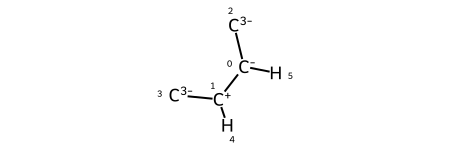

In [3]:
homologs.atXYZ.sel(cmpnd='A03').isel(frame=0).sh.to_mol(to2D=False)

In [4]:
dih = homologs.atXYZ.sh.dihedral(3, 1, 0, 2, deg=True)
dih

<xarray.DataArray 'dihedral' (frame: 53332)> Size: 427kB
array([  2.19650568,   2.18585872,   2.34416698, ..., 157.76520892,
       160.6599355 , 163.70932658], shape=(53332,))
Coordinates:
  * frame    (frame) object 427kB MultiIndex
  * cmpnd    (frame) <U3 640kB 'I01' 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid   (frame) int64 427kB 2 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time     (frame) float64 427kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
Attributes:
    long_name:  $\varphi_{3,1,0,2}$

In [135]:
desc_list = [
        # homologs.atXYZ.sh.angle(3, 1, 4),
        # homologs.atXYZ.sh.angle(5, 0, 2),
        homologs.atXYZ.sh.dihedral(3, 1, 0, 5, deg=True),
        homologs.atXYZ.sh.dihedral(3, 1, 0, 2, deg=True),
        homologs.atXYZ.sh.dihedral(4, 1, 0, 5, deg=True),
        homologs.atXYZ.sh.dihedral(4, 1, 0, 2, deg=True),
]
for i, desc in enumerate(desc_list):
    desc_list[i] = desc.assign_coords(descriptor=desc.attrs['long_name'])
descriptors = xr.concat(desc_list, dim="descriptor")
descriptors

<xarray.DataArray 'dihedral' (descriptor: 4, frame: 53332)> Size: 2MB
array([[179.26636367, 179.06357923, 178.65471531, ...,  55.48874298,
         53.85377912,  51.85263529],
       [  2.19650568,   2.18585872,   2.34416698, ..., 157.76520892,
        160.6599355 , 163.70932658],
       [ 16.03292716,  18.27630274,  20.35114121, ..., 177.14425188,
        176.71784523, 176.45301285],
       [165.42994219, 162.97313521, 160.64774108, ...,  36.10970002,
         37.79586939,  39.10894902]], shape=(4, 53332))
Coordinates:
  * frame       (frame) object 427kB MultiIndex
  * cmpnd       (frame) <U3 640kB 'I01' 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid      (frame) int64 427kB 2 2 2 2 2 2 2 ... 316 316 316 316 316 316
  * time        (frame) float64 427kB 0.0 0.5 1.0 1.5 ... 76.5 77.0 77.5 78.0
  * descriptor  (descriptor) <U19 304B '$\\varphi_{3,1,0,5}$' ... '$\\varphi_...
Attributes:
    long_name:  $\varphi_{3,1,0,5}$

In [121]:
dpca, dpca_obj = descriptors.sh.pca('descriptor', return_pca_object=True)
dpca['dih'] = homologs.atXYZ.sh.dihedral(3, 1, 0, 2, deg=True)
dpca

<xarray.DataArray 'dihedral' (frame: 53332, PC: 2)> Size: 853kB
array([[-0.79915361,  0.07788439],
       [-0.78514578,  0.08992586],
       [-0.77099457,  0.10010115],
       ...,
       [ 0.78285956,  0.05695076],
       [ 0.78892824,  0.03830294],
       [ 0.79792671,  0.01962107]], shape=(53332, 2))
Coordinates:
  * frame    (frame) object 427kB MultiIndex
  * cmpnd    (frame) <U3 640kB 'I01' 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid   (frame) int64 427kB 2 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time     (frame) float64 427kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
    dih      (frame) float64 427kB 2.197 2.186 2.344 2.744 ... 157.8 160.7 163.7
Dimensions without coordinates: PC

In [122]:
loadings = xr.DataArray(
    data=dpca_obj.components_,
    dims=['PC', 'descriptor'],
    coords=dict(
        descriptor=descriptors.descriptor
    )
)
loadings

<xarray.DataArray (PC: 2, descriptor: 4)> Size: 64B
array([[-0.49874577,  0.46546689,  0.53353738, -0.4999311 ],
       [ 0.55840187, -0.46598984,  0.41966641, -0.54306623]])
Coordinates:
  * descriptor  (descriptor) <U19 304B '$\\varphi_{3,1,0,5}$' ... '$\\varphi_...
Dimensions without coordinates: PC

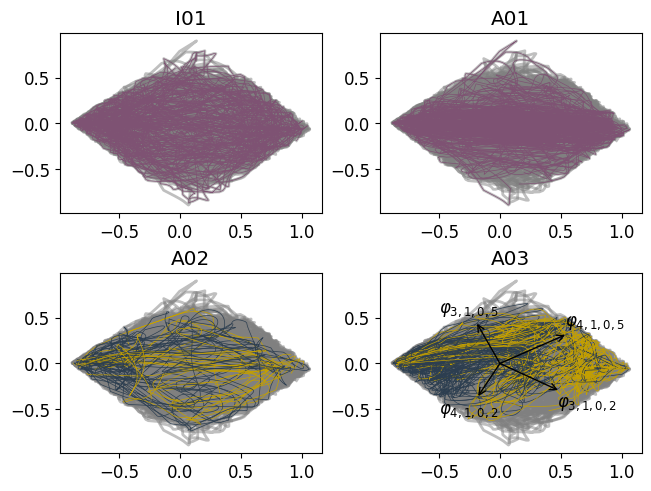

In [123]:
plt.rc('font', size=12)
plt.rc('lines', linewidth=2)

fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')

for name, ax in axs.items():
    ax.set_title(name)
    for (cmpnd, trajid), traj in dpca.sh.mgroupby(['cmpnd', 'trajid']):
        ax.plot(traj[:,0], traj[:,1], c='gray', alpha=0.5)

for (cmpnd, trajid), traj in dpca.sh.mgroupby(['cmpnd', 'trajid']):
    if cmpnd in {'I01', 'A01'}:
        c = '#7E5273'
    elif traj['dih'].isel(frame=-1) < 80:
        c = '#2c3e50'
    elif traj['dih'].isel(frame=-1) > 100:
        c = '#C4A000'
    axs[cmpnd].plot(traj[:,0], traj[:,1], c=c, lw=0.5)

for label, pcs in loadings.groupby('descriptor'):
    pc1, pc2 = pcs.item(0), pcs.item(1)
    axs['A03'].annotate(label, xy=(0, 0), xytext=(pc1, pc2), arrowprops=dict(arrowstyle="<-", shrinkB=0))

Text(0, 0.5, 'PC2')

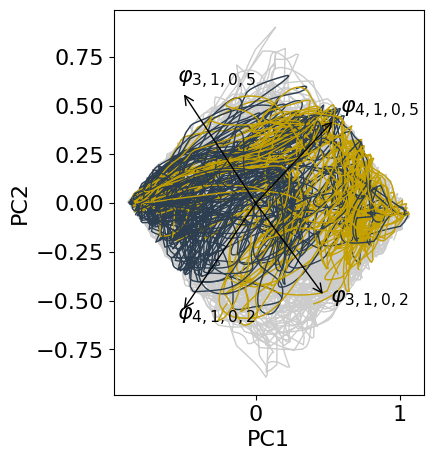

In [133]:
plt.rc('font', size=16)
plt.rc('lines', linewidth=1)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 5)

# Grey background:
for (cmpnd, trajid), traj in dpca.sh.mgroupby(['cmpnd', 'trajid']):
        ax.plot(traj[:,0], traj[:,1], c='#ccc', alpha=1)

# Trajectories as lines, coloured by end-dihedral
for trajid, traj in dpca.sel(cmpnd='A03').groupby('trajid'):
    if traj['dih'].isel(frame=-1) < 80:
        c = '#2c3e50'
    elif traj['dih'].isel(frame=-1) > 100:
        c = '#C4A000'
    ax.plot(traj[:,0], traj[:,1], c=c)

# Loadings as arrows
for label, pcs in loadings.groupby('descriptor'):
    pc1, pc2 = pcs.item(0), pcs.item(1)
    # Draw arrow:
    ax.annotate('', xy=(0, 0), xytext=(pc1, pc2), arrowprops=dict(arrowstyle="<-", shrinkA=0, shrinkB=0))
    ax.text(pc1*1.1, pc2*1.1, label)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')